### 0.0 Package environment setup

In [96]:
# Required Imports
from selenium import webdriver
from bs4 import BeautifulSoup as bs
from utility import *
from keys import *

import time
import pandas as pd
import numpy as np
import re

In [2]:
def htmlTable2df(raw_html):
    row = re.compile('<tr>(.*?)</tr>')
    row_ls = re.findall(row,raw_html)
    cell = re.compile('t.*?>(.*?)</t')
    table_ls = [re.findall(cell,c) for c in row_ls]
    company_df = pd.DataFrame(table_ls[1:],columns = table_ls[0])
    return company_df

In [3]:
def removeNuance(x):
    r = x.replace('&amp;','and')
    return r

### 1.0 get company list

In [59]:
import random
from googlesearch import search

def getLinkedinLink(df):
    Linkedin_ls = []
    start = time.time()
    total = df.shape[0]
    
    for i,row in df.iterrows():
        while(True):
            try:
                urls = search(row['name']+' linkedin',num_results=10)
                for u in urls:
                    if 'linkedin' in u:
                        linkedin_url = u
                        break
                    else:
                        linkedin_url = 'na'

                Linkedin_ls.append(linkedin_url)
                break
            except IndexError:
                Linkedin_ls.append('not found')
            except Exception as err:
                print(err)
                time.sleep(random.randrange(0,20))
        print('searching linkedin page:',i+1,'/',total,'time elapse:',time.time()-start,end='\r')

    df['Linkedin']=pd.Series(Linkedin_ls)
    
    return df

In [52]:
pages = {'https://www.enr.com/toplists/2021-Top-500-Design-Firms-':5,
         'https://www.enr.com/toplists/2021-Top-400-Contractors-':4,
         'https://www.enr.com/toplists/2020-Top-150-Global-Design-Firms-':2,
         'https://www.enr.com/toplists/2020-Top-250-Global-Contractors-':3}

In [53]:
#accessing Chromedriver
browser = webdriver.Chrome('chromedriver')

#Open login page
browser.get(ENR_cred['login url'])

#Enter login info:
elementID = browser.find_element_by_id('id13')
elementID.send_keys(ENR_cred['username'])

elementID = browser.find_element_by_id('id16')
elementID.send_keys(ENR_cred['password'])
elementID.submit()

In [54]:
containers={}
for key,value in pages.items():
    containers[key] = []
    for i in range(value):
        browser.get(key+str(i+1))
        company_page = browser.page_source
        
        enr_soup = bs(company_page.encode('utf-8'),'html')
        enr_soup.prettify()
        
        containers[key].append(enr_soup.findAll("table",{"class":"dcf-table dcf-table-responsive dcf-table-bordered dcf-table-striped dcf-w-100%"}))

In [55]:
dataframes = []

for key,content in containers.items():
    companies_df = pd.DataFrame()
    for table_list in content:
        raw_html=str(table_list[0]).replace('\n','')
        segament_df = htmlTable2df(raw_html)
        #print(segament_df)
        companies_df=companies_df.append(segament_df,ignore_index=True)
    dataframes.append(companies_df)

# dataframes

In [57]:
design_df = dataframes[0]

design_df['name'] = design_df['FIRM'].apply(lambda x: x.split(',')[0])
design_df['city'] = design_df['FIRM'].apply(lambda x: x.split(',')[1])
design_df['state'] = design_df['FIRM'].apply(lambda x: x.split(',')[2])
design_df = design_df.drop('FIRM',axis=1)

In [56]:
contractor_df = dataframes[1]
g_design_df = dataframes[2]
g_contractor_df = dataframes[3]

contractor_df['name'] = contractor_df['FIRM'].apply(lambda x: x.split(',')[0])
g_design_df['name'] = g_design_df['FIRM'].apply(lambda x: x.split(',')[0])
g_contractor_df['name'] = g_contractor_df['FIRM'].apply(lambda x: x.split(',')[0])

In [58]:
design_df['name'] = design_df['name'].apply(removeNuance)
contractor_df['name'] = contractor_df['name'].apply(removeNuance)
g_design_df['name'] = g_design_df['name'].apply(removeNuance)
g_contractor_df['name'] = g_contractor_df['name'].apply(removeNuance)

In [60]:
contractor_df = getLinkedinLink(contractor_df)
g_design_df = getLinkedinLink(g_design_df)
g_contractor_df = getLinkedinLink(g_contractor_df)

In [62]:
contractor_df.head()

,RANK 2021,RANK 2020,FIRM,2021,2020,name,Linkedin
0,1,2,"THE TURNER CORP., New York, N.Y.",NaN,NaN,THE TURNER CORP.,https://www.linkedin.com/company/turner-constr...
1,2,1,"BECHTEL, Reston, Va.†",NaN,NaN,BECHTEL,https://www.linkedin.com/company/bechtel-corpo...
2,3,**,"FLUOR, Irving, Texas†",NaN,NaN,FLUOR,https://ca.linkedin.com/company/fluor
3,4,5,"KIEWIT CORP., Omaha, Neb.†",NaN,NaN,KIEWIT CORP.,https://www.linkedin.com/company/kiewit
4,5,4,"THE WHITING-TURNER CONTRACTING CO., Baltimore,...",NaN,NaN,THE WHITING-TURNER CONTRACTING CO.,https://www.linkedin.com/company/the-whiting-t...


### 2.0 Linkedin post scraper.

In [69]:
# Required Imports
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import time
import pandas as pd
import re

In [71]:
from keys import *

In [94]:
#accessing Chromedriver
browser = webdriver.Chrome('chromedriver')


#Open login page
browser.get(LINKEDIN_cred['login url'])

#Enter login info:
elementID = browser.find_element_by_id('username')
elementID.send_keys(LINKEDIN_cred['username'])

elementID = browser.find_element_by_id('password')
#elementID.send_keys(LINKEDIN_cred['password'])
elementID.send_keys('ThruSilver27')
elementID.submit()

In [74]:
default_selectors = {'post':['div',{"class":"feed-shared-update-v2 feed-shared-update-v2--minimal-padding full-height relative feed-shared-update-v2--e2e artdeco-card ember-view"}],
                     'date':['span',{"class":"visually-hidden"}],
                     'text':['span',{"class":"break-words"}],
                     'reaction':['span',{"class":"v-align-middle social-details-social-counts__reactions-count"}],
                     'comment':['li',{"class": "social-details-social-counts__comments social-details-social-counts__item"}]
                    }

In [76]:
def getLinkedinPosts(linkedinLink,selector=default_selectors['post']):
    #Go to company post webpage
    browser.get(linkedinLink + '/posts/')

    #Simulate scrolling to capture all posts
    SCROLL_PAUSE_TIME = 1.5

    # Get scroll height
    last_height = browser.execute_script("return document.body.scrollHeight")

    while True:
        # Scroll down to bottom
        browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

        # Wait to load page
        time.sleep(SCROLL_PAUSE_TIME)

        # Calculate new scroll height and compare with last scroll height
        new_height = browser.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height
    company_page = browser.page_source  
    company_soup = bs(company_page.encode("utf-8"), "html")
    company_soup.prettify()
    
    containers = company_soup.findAll(selector[0],selector[1])
    return containers

In [77]:
def containers2lists(containers,selectors=default_selectors):
    # Lists that we will iterate to
    post_dates = []
    post_texts = []
    post_react = []

    #Looping through the posts and appending them to the lists
    for container in containers:

        #Try function to make sure its a post and not a promotion
        try:
            posted_date = container.find(selectors['date'][0],selectors['date'][1])
            text_box    = container.find(selectors['text'][0],selectors['text'][1])
            text        = text_box.find("span",{"dir":"ltr"})
            reaction    = container.find(selectors['reaction'][0],selectors['reaction'][1])

            post_dates.append(posted_date.text.strip())
            post_texts.append(text.text.strip())
            post_react.append(int(reaction.text.strip()))

        except:
            pass
    return {'texts':post_texts,'dates':post_dates,'reactions':post_react}

In [92]:
def linkedin2containers_ls(df,containers_ls=[], skip = 0):
    total = df.shape[0]
    start = time.time()
    
    for i,row in df.iterrows():
        if i < len(containers_ls)+skip:
            pass
        else:
            try:
                containers_ls.append(getLinkedinPosts(row['Linkedin']))
            except:
                containers_ls.append(np.nan)
        print('scraped Linkedin posts',i+1,'/',total,'time elapse:',time.time()-start,end='\r')

    print('task completed')
    return containers_ls

In [97]:
contractor_containers_ls = linkedin2containers_ls(contractor_df,contractor_containers_ls)

task completedin posts 400 / 400 time elapse: 111.2082493305206344349 / 400 time elapse: 0.1730809211730957


In [101]:
len(contractor_containers_ls[1])

9

In [ ]:
result_ls = []
total = len(containers_ls)
start = time.time()
i = 1
for containers in containers_ls:
    result_ls.append(containers2lists(containers))
    print('sorting containers',i,'/',total,'time elapse:',time.time()-start,end='\r')
    i+=1

In [ ]:
design_posts_df = pd.DataFrame(columns=['company','post','date','reaction_count'])
i=0
for d in result_ls:
    for j in range(len(d['texts'])):
        print(i,'-',j,end='\r')
        try:
            row_df = pd.DataFrame([[design_df['name'][i],d['texts'][j],d['dates'][j],d['reactions'][j]]],columns=['company','post','date','reaction_count'])
            design_posts_df=design_posts_df.append(row_df,ignore_index=True)
        except IndexError:
            pass
    i+=1

design_posts_df.head()

### 2.1 saving and loading dataframes from pickle files

In [5]:
import pickle

with open('design_df.pkl','rb') as infile:
    design_df = pickle.load(infile)
    
with open('design_posts_df.pkl','rb') as infile:
    design_posts_df = pickle.load(infile)

In [55]:
from transformers import pipeline

with open('HF_sentiment-analysis.pkl','rb') as infile:
    HF_sa = pickle.load(infile)

In [144]:
with open('design_df.pkl','wb') as outfile:
    pickle.dump(design_df,outfile)
    
with open('design_posts_df.pkl','wb') as outfile:
    pickle.dump(design_posts_df,outfile)

### 3.0 open AI sentiment analysis debatable due to the cost of the operation.

In [6]:
import os
import openai
from keys import *

openai.api_key = OPENAI_API_KEY

In [7]:
# this part utilize openai engine and it doesn't help with the 
def openaiWraper(text,application = 'sentiment classifier',engine = 'davinci'):
    if application == 'sentiment classifier':
        text_prompt = f'This is a Linkedin post sentiment classifier \nLinkedin post:"{text}"\nSentiment:'
        max_token = 3
    else:
        text_prompt = text
        max_token = 60
        
    response = openai.Completion.create(
      engine=engine,
      prompt=text_prompt,
      temperature=0.3,
      max_tokens=max_token,
      top_p=1.0,
      frequency_penalty=0.5,
      presence_penalty=0.0,
      stop=["###"]
    )
    
    text_return = response['choices'][0]['text']
    
    if application == 'sentiment classifier':
        result = text_return.split()[0]
    else:
        result = text_return
    
    return result

In [20]:
#sentiment_LS = []
i = 0
total = design_posts_df.shape[0]
start = time.time()

for i,row in design_posts_df.iterrows():
    i+=1
    if i<500:
        continue
        
    try:
        feedback = openaiWraper(row['post'],engine='curie').lower()
    except:
        feedback='error'
    j = 0
    
    while('negative' not in feedback and 
          'positive' not in feedback and 
          'neutral' not in feedback and j<10):
        try:
            feedback = openaiWraper(row['post'],engine='curie').lower()
        except:
            feedback='error'
        j += 1
    if 'negative' not in feedback and \
       'positive' not in feedback and \
        'neutral' not in feedback:
        feedback = 'undefined'
    sentiment_LS.append(feedback)
    print('completed:',i,'/',total,'elapse:',time.time()-start,end='\r')
    
#len(sentiment_LS)

In [39]:
emo_ls = []
i=0
while(True):
    try:
        emo_i = sentiment_LS.index('undefined',i)
        emo_ls.append(emo_i)
        i = emo_i+1
    except:
        print('completed')
        break
len(emo_ls)

completed


5

In [36]:
5+474+4

483

In [28]:
#sentiment_LS
design_posts_df['post'][84]

'A best practice report from Urban Land Institute looks at how to define, create and optimize social value across the real estate industry.Jacobs Director of Economics Margarethe Theseira: "Jacobs recognized the global pivot that is underway in moving investment decisions away from solely creating maximum financial return to a more holistic measurement framework that also includes wellbeing, environment and societal impacts. We are pleased to be working in partnership with Simetrica-Jacobs to provide our clients a bespoke approach to delivering social value through the design, build & operational phases of their investments.”Head of Cities Solutions Carlo Castelli said: “Our ability to use #socialvalue to tackle the spatial divide & empower individuals, communities & businesses to thrive is improving dramatically, but it requires constant focus to support the U.K.’s levelling up agenda and a holistic approach to human development.”Read the key findings ⬇️ http://jcob.co/mNht50E2pcKSpec

In [ ]:
test_LS=[s.replace('"','') for s in sentiment_LS]

### 4.0 bag of keywords occurance check.

In [31]:
# keywords extracted from the Lexicon

keyword_ls=['team',
           'capacity',
           'effect',
           'product',
           'value',
           'quality',
           'capab',
           'skill',
           'community',
            'communicat',
           'reliab',
           'inform',
           'train',
            'know',
            'change',
            'ability',
            'cultur',
            'network',
            'tradition',
            'learn',
            'transition',
            'perform'
          ]

In [40]:
design_df.to_csv('top500_design_firm.csv')
design_posts_df.to_csv('top500_design_firm_linkedin_posts.csv')

In [24]:
def getPostCount(name):
    try:
        return design_posts_df.groupby('company')['post'].count()[name]
    except:
        return 0

In [25]:
design_df['post_count']=design_df['name'].apply(getPostCount)

In [29]:
import seaborn as sns

<AxesSubplot:xlabel='post_count', ylabel='Count'>

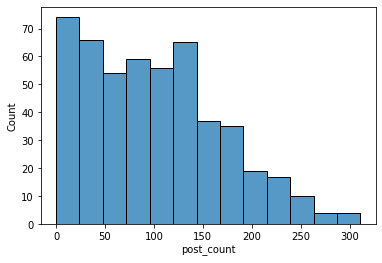

In [30]:
sns.histplot(design_df['post_count'])

In [51]:
design_posts_df.groupby('company')['post'].count().median()

101.0

In [48]:
design_df

,RANK 2021,RANK 2020,FIRM TYPE,name,city,state,Linkedin,count
0,1,1,EAC,Jacobs,Dallas,Texas†,https://www.linkedin.com/company/jacobs,NaN
1,2,2,EA,AECOM,Los Angeles,Calif.,https://ca.linkedin.com/company/aecom,NaN
2,3,**,EC,Fluor Corp.,Irving,Texas†,https://www.linkedin.com/company/fluor,NaN
3,4,4,E,Tetra Tech Inc.,Pasadena,Calif.,https://www.linkedin.com/company/tetra-tech,NaN
4,5,**,EC,Worley,Houston,Texas†,https://au.linkedin.com/company/worley,NaN
...,...,...,...,...,...,...,...,...
495,496,**,A,KSS Architects,Princeton,N.J.,https://www.linkedin.com/company/kss-architects,NaN
496,497,**,EA,Lane Bishop York Delahay Inc.,Birmingham,Ala.,https://www.linkedin.com/company/lbyd-inc.,NaN
497,498,**,E,H.F. Lenz Co.,Johnstown,Pa.,https://www.linkedin.com/company/h.f.-lenz-com...,NaN
498,499,**,A,Harvard Jolly Architecture,St. Petersburg,Fla.,https://www.linkedin.com/company/harvard-jolly,NaN


In [37]:
post_texts = [row['post'].lower() for i,row in design_posts_df.iterrows()]

In [38]:
keyword_chk = {k:sum([k in t for t in post_texts]) for k in keyword_ls}

In [71]:
keyword_dict=dict(sorted(keyword_chk.items(), key=lambda item: item[1],reverse=True))

In [72]:
keyword_dict

{'team': 10233,
 'learn': 8609,
 'community': 4391,
 'know': 2618,
 'ability': 2616,
 'change': 2415,
 'inform': 1736,
 'quality': 1570,
 'cultur': 1565,
 'perform': 1332,
 'value': 1177,
 'train': 983,
 'effect': 955,
 'product': 861,
 'network': 781,
 'skill': 769,
 'communicat': 743,
 'transition': 454,
 'tradition': 409,
 'capab': 393,
 'capacity': 335,
 'reliab': 308}

In [77]:
keyword_df = pd.DataFrame.from_dict(keyword_dict,orient='index')

In [78]:
keyword_df.head()

,0
team,10233
learn,8609
community,4391
know,2618
ability,2616


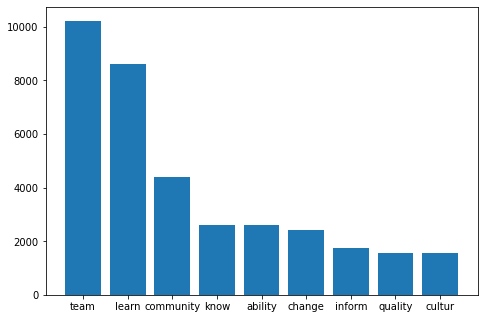

In [150]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(keyword_df.index[:9],keyword_df[0][:9])
#ax.xlabel('')
plt.show()

+ wall street journal
+ forbes
+ cnn
+ washington post
+ msnbc
+ financial times
+ enr